In [1]:
from minimal_model import ref_parameters,  I0, sensitivity_analysis, PARAMETER_NAMES
from minimal_model import perturbation_dynamics
import numpy as np
import re

In [2]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator


# Set font size and style in matplotlib
plt.rcParams.update({'font.size': 12, 'font.family': 'Arial'})

# Error bar kwargs for prism style plots
errorbar_kwargs = {'capsize': 2, 'capthick': 1, 'elinewidth': 1, 'zorder': 10}

# Spine properties
spine_properties = {'color': 'black', 'linewidth': 2}

# TODO Better colors for this figure

# Color palate with basal, default, and perturbation colors
colors_basal = ['whitesmoke','lightsteelblue', 'steelblue']

# Color palate default, perturbation
colors_default = ['dimgrey', 'indianred'] 



In [3]:
# Scaling 
# ATP per O2 (3 per O)
PO2 = 5.0
# Whole body oxygen consumption rate ~ 2000 nmol/min/gBW
vO2 = 2000 * 0.7 
# ATP production rate
vATP = PO2 * vO2 
# Scale the oxygen fluxes by vE
vE = vATP 


In [4]:
# Used fited parameters
KI_lipo = 2.2020029482208465
KA_glut4 = 1.0000000000001559
KA_glut_GL = 0.9999999999999826
KI_GL = 1.0000000000000016
KIL = 1.0000000000000264
KIK = 1.0000000000000018
KF = 6.4578909628670385
KG = 112.54985574266506
KFK = 219.14566047491553
KL = 210.40142710462985
KI_F = 0.0010000000000033762
v_in_F = 0.007949666179418913

p_fited = ref_parameters( KI_lipo,  KA_glut4, KA_glut_GL, KIL, KIK, KF, KG, KFK, KL, KI_F,)

In [5]:
# compute sensitivity indices 

SENS_PARAMS = [ "Imax", 'C',
                "KI_lipo", "KA_glut4",  "KI_F", "omega", 
               "lam", "gamma", "beta", "kappa", "alpha", "VR", "VFK", 
                "VLG",  "v0",]

# Map parameters interms of pth
PARAMETER_DESCRIPTIONS = {
    'Imax':'Insulin secretion (capacity)',
    'C': 'Insulin secretion (threshold)',
    'KI_lipo' : 'Insulin receptor signaling (adipose)',
    'KA_glut4' : 'Insulin receptor signaling (muscle)',
    'KI_F' : 'Insulin receptor signaling (liver)',
    'omega': 'Carbohydrate metabolism (glycolysis)',
    'lam': 'Carbohydrate metabolism (lactate oxidation)',
    'gamma': 'Carbohydrate metabolism (glucose oxidation)',
    'VLG': 'Carbohydrate metabolism (gluconeogenesis)',
    'beta': 'Fatty acid oxidation',
    'kappa': 'Ketone metabolism (oxidation)',
    'VFK': 'Ketone metabolism (ketogenesis)',
    'alpha': 'Triglyceride catabolism (lipolysis)',
    'VR' : 'Triglyceride biosynthesis (re-esterification)',
    'v0': 'Glycogen breakdown'
}

# Mapp direction dowards loss of pathways activity
PARAMETER_DIRECTION = {
    "Imax": -1,
    "C":1,
    "KI_lipo": 1, 
    "KA_glut4": 1,  
    "KI_F" : 1,
    "omega" : -1 , 
    "lam" : -1 , 
    "gamma": -1, 
    "beta" : -1 , 
    "kappa": -1, 
    "alpha" : -1 , 
    "VR": -1,
    "VFK": -1, 
    "VLG": -1 , 
    "v0": -1 ,
}

# We simulate loss of pathway activity
FOLD_CHANGE = {
    "Imax": 0.5,
    'C': 2.0,
    "KI_lipo": 2, 
    "KA_glut4": 2,  
    "KI_F" : 2,
    "omega" : 0.5 , 
    "lam" : 0.5, 
    "gamma": 0.5, 
    "beta" : 0.5, 
    "kappa": 0.5, 
    "alpha" : 0.5, 
    "VR": 0.5,
    "VFK": 0.5, 
    "VLG": 0.5, 
    "v0": 0.5,
}   



results_healthy = dict()
results_obese = dict()
for p in SENS_PARAMS:
    S_0 = sensitivity_analysis(p,1.0, p_fited, fold_change=FOLD_CHANGE[p])
    S_10 = sensitivity_analysis(p,10.0, p_fited, fold_change=FOLD_CHANGE[p])

    results_healthy[p] = S_0
    results_obese[p] = S_10


df_healthy = pd.DataFrame(results_healthy).T
df_obese = pd.DataFrame(results_obese).T

# Drop the last colums - they fluxes that are 0 by definition
df_healthy = df_healthy.drop(columns=["v_in_L","v_in_G","v_in_F","v_in_K","vI"], axis=1)
#df_obese = df_obese.drop(columns=["v_in_L","v_in_G","v_in_F","v_in_K","vI"], axis=1)

# Add a condition column
df_healthy["Condition"] = "Healthy"
#df_obese["Condition"] = "Obese"

df = pd.concat([df_healthy, df_obese])
df = df_healthy
df.reset_index(inplace=True)
df = df.rename(columns={"index": "Parameter"})

# Map parameter effects to loss in pathways
df["Direction"]  = df["Parameter"].map(PARAMETER_DIRECTION)


# Map the parameter names to the descriptions
df["ParameterDescription"] = df["Parameter"].map(PARAMETER_DESCRIPTIONS)

# Map Pathway from Parameter de

df["Pathway"] = df["ParameterDescription"].apply(lambda text: re.sub(r'\s*\(.*?\)', '', text))

# K parameters are 1/K in the model so multiply by -1 for clarity
# If parameter description contains "Affinity" multiply by -1
# Get numierical columns
# num_col = df.select_dtypes(include=[np.number]).columns
# df.loc[:, num_col[:-1]] = df.loc[:, num_col[:-1]].multiply(df["Direction"], axis =0)




/Users/dw6835/src/competitive_catabolism/minimal_model/minimal_model.py:571: RuntimeWarning: invalid value encountered in true_divide
  dF = np.log(F_1/F0) / np.log(fold_change)
/Users/dw6835/src/competitive_catabolism/minimal_model/minimal_model.py:571: RuntimeWarning: invalid value encountered in true_divide
  dF = np.log(F_1/F0) / np.log(fold_change)
/Users/dw6835/src/competitive_catabolism/minimal_model/minimal_model.py:571: RuntimeWarning: invalid value encountered in log
  dF = np.log(F_1/F0) / np.log(fold_change)
/Users/dw6835/src/competitive_catabolism/minimal_model/minimal_model.py:571: RuntimeWarning: invalid value encountered in true_divide
  dF = np.log(F_1/F0) / np.log(fold_change)
/Users/dw6835/src/competitive_catabolism/minimal_model/minimal_model.py:571: RuntimeWarning: invalid value encountered in log
  dF = np.log(F_1/F0) / np.log(fold_change)
/Users/dw6835/src/competitive_catabolism/minimal_model/minimal_model.py:571: RuntimeWarning: invalid value encountered in true

In [6]:
# Categorical ordering in df
order_list = [
    'Insulin secretion',
    'Insulin receptor signaling', 
    'Carbohydrate metabolism',
    'Fatty acid oxidation', 
    'Ketone metabolism',
    'Triglyceride biosynthesis',
    'Triglyceride catabolism',
    'Glycogen breakdown',
]

df['Pathway'] = pd.Categorical(df['Pathway'], categories=order_list, ordered=True)



In [7]:
df

,Parameter,L,G,F,K,I,vL,vG,vF,vK,vGL,vFK,vLG,v0,vA,vR,Condition,Direction,ParameterDescription,Pathway
0,Imax,-5.423228e-03,-2.002513e-01,1.919244e-02,-0.157559,3.667493e-01,-5.134116e-04,-3.440968e-04,0.024102,-1.526497e-01,-3.440968e-04,-1.526497e-01,-5.407650e-06,-0.0,-1.238080e-01,-1.802513e-01,Healthy,-1,Insulin secretion (capacity),Insulin secretion
1,C,-1.028122e-01,6.286243e-01,-1.591047e-01,0.220857,-1.215097e+00,1.173148e-03,7.467403e-04,-0.055119,3.248425e-01,7.467403e-04,3.248425e-01,-1.064539e-04,0.0,3.299860e-01,4.672725e-01,Healthy,1,Insulin secretion (threshold),Insulin secretion
2,KI_lipo,1.953760e-01,7.726690e-02,1.865563e-01,0.252170,2.467677e-01,1.673666e-04,1.724288e-04,-0.008652,5.696099e-02,1.724288e-04,5.696099e-02,1.825532e-04,0.0,1.800442e-01,2.617098e-01,Healthy,1,Insulin receptor signaling (adipose),Insulin receptor signaling
3,KA_glut4,0.000000e+00,0.000000e+00,-1.601713e-16,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,-3.203427e-16,0.000000e+00,0.0,0.000000e+00,0.000000e+00,Healthy,1,Insulin receptor signaling (muscle),Insulin receptor signaling
4,KI_F,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,-3.203427e-16,0.000000e+00,0.0,0.000000e+00,0.000000e+00,Healthy,1,Insulin receptor signaling (liver),Insulin receptor signaling
5,omega,8.436686e-01,-1.228871e-01,3.666283e-01,1.009128,-3.911085e-01,4.084040e-01,-7.404928e-01,-0.068636,5.738634e-01,2.595072e-01,5.738634e-01,1.144777e-03,-0.0,1.606022e-01,2.414698e-01,Healthy,-1,Carbohydrate metabolism (glycolysis),Carbohydrate metabolism
6,lam,-9.998240e-01,-3.386911e-05,9.016675e-05,0.000248,-1.087492e-04,7.195510e-05,-1.923180e-04,-0.000014,1.441161e-04,-1.923180e-04,1.441159e-04,-7.207190e-04,-0.0,4.036949e-05,5.565744e-05,Healthy,-1,Carbohydrate metabolism (lactate oxidation),Carbohydrate metabolism
7,gamma,-1.327152e-01,-2.473821e-02,6.923672e-02,0.193863,-7.930025e-02,-2.174664e-01,8.514052e-01,-0.015515,1.091118e-01,-1.485948e-01,1.091118e-01,-1.266727e-04,-0.0,3.004675e-02,4.401638e-02,Healthy,-1,Carbohydrate metabolism (glucose oxidation),Carbohydrate metabolism
8,beta,4.564381e-01,1.651384e-01,-4.126630e-01,-0.194268,5.353639e-01,-2.689113e-03,-1.614789e-03,0.128210,-6.533949e-01,-1.614789e-03,-6.533949e-01,5.362627e-04,-0.0,-1.730197e-01,-2.440325e-01,Healthy,-1,Fatty acid oxidation,Fatty acid oxidation
9,kappa,1.121199e-15,3.203427e-16,-1.601713e-15,-1.000000,1.121199e-15,2.883084e-15,2.082227e-15,-0.000000,-7.367881e-15,2.242399e-15,-1.922056e-15,1.601713e-16,-0.0,-6.406853e-16,-9.610280e-16,Healthy,-1,Ketone metabolism (oxidation),Ketone metabolism


In [8]:
df.groupby("Pathway")["G"].max().sort_values(ascending=False).index


CategoricalIndex(['Insulin secretion', 'Triglyceride catabolism',
                  'Fatty acid oxidation', 'Glycogen breakdown',
                  'Insulin receptor signaling', 'Carbohydrate metabolism',
                  'Ketone metabolism', 'Triglyceride biosynthesis'],
                 categories=['Insulin secretion', 'Insulin receptor signaling', 'Carbohydrate metabolism', 'Fatty acid oxidation', 'Ketone metabolism', 'Triglyceride biosynthesis', 'Triglyceride catabolism', 'Glycogen breakdown'], ordered=True, dtype='category', name='Pathway')

In [9]:
df.groupby("Pathway")["G"].max()

Pathway
Insulin secretion             0.628624
Insulin receptor signaling    0.077267
Carbohydrate metabolism       0.036215
Fatty acid oxidation          0.165138
Ketone metabolism             0.016843
Triglyceride biosynthesis    -0.183073
Triglyceride catabolism       0.328395
Glycogen breakdown            0.155026
Name: G, dtype: float64

In [10]:
# Find the extreme value in if many:
def find_largest_magnitude(arr):
    if isinstance(arr, pd.Series):
        if arr.empty:
            return None  # Return None if the Series is empty
        largest_magnitude = arr.abs().idxmax()
        return arr[largest_magnitude]
    elif isinstance(arr, list):
        if not arr:
            return None  # Return None if the list is empty
        largest_magnitude = max(arr, key=abs)
        return largest_magnitude
    else:
        raise TypeError("Input should be a pandas Series or a list")

In [11]:
df_pathway = df.groupby('Pathway')[['G','L','F','K','I']].aggregate(lambda x: np.max(abs(x))).T
df_pathway['MAPPED_TRAIT'] = ['Glucose', 'Lactate','Fatty acids','Ketones','Insulin',]

df_pathway = df_pathway.melt(id_vars=['MAPPED_TRAIT'])


/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_27791/2246209796.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, y="MAPPED_TRAIT" ,x='value', ax=ax,
/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_27791/2246209796.py:11: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.barplot(data=subset, y="MAPPED_TRAIT" ,x='value', ax=ax,
/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_27791/2246209796.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset, y="MAPPED_TRAIT" ,x='value', ax=ax,
/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_27791/2246209796.py:11: UserWarning: The pa

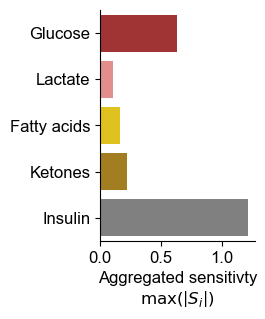

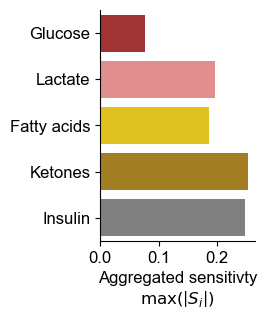

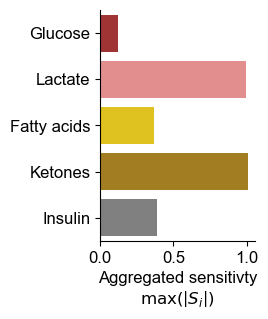

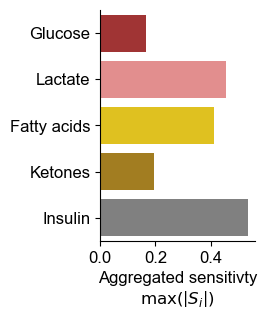

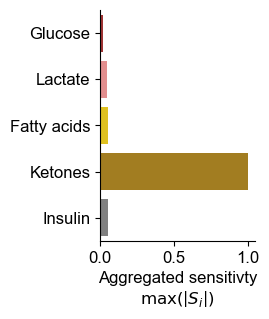

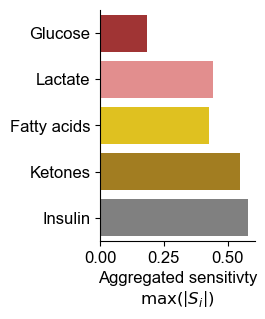

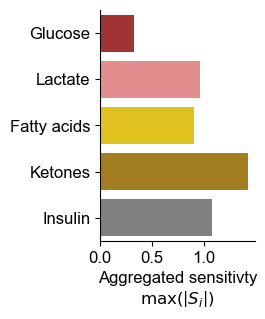

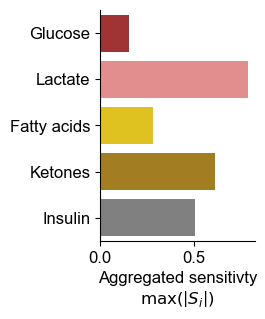

In [12]:

order = ['Glucose', 'Lactate','Fatty acids','Ketones','Insulin',] # 'Diabetes',]

colors_met = ['firebrick', 'lightcoral',  'gold' ,'darkgoldenrod', 'grey' , 'black']

# Make plot for each pathway:
for p in df_pathway.Pathway.unique():
    subset = df_pathway[(df_pathway.Pathway == p)  ].reset_index()

    fig, ax = plt.subplots(1, 1, figsize=(2, 3),)

    sns.barplot(data=subset, y="MAPPED_TRAIT" ,x='value', ax=ax, 
            palette=colors_met, legend=False, order=order)


    sns.despine()
    ax.set_xlabel("Aggregated sensitivty\n$\max(\left|S_i\\right|)$")
    ax.set_ylabel("")

    plt.savefig(f"output/trait_effects_{p}.svg", bbox_inches='tight')

In [13]:
subset

,index,MAPPED_TRAIT,Pathway,value
0,35,Glucose,Glycogen breakdown,0.155026
1,36,Lactate,Glycogen breakdown,0.785318
2,37,Fatty acids,Glycogen breakdown,0.282199
3,38,Ketones,Glycogen breakdown,0.608143
4,39,Insulin,Glycogen breakdown,0.502316


/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_27791/1559711.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, y="Pathway" ,x='G', ax=ax, legend=False,
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


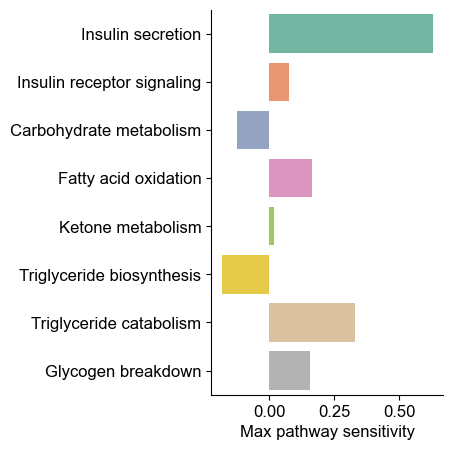

In [14]:
# Make a bar graph of the glucose sensitivity indices
fig, ax = plt.subplots(1, 1, figsize=(3, 5),)

# Order by the glucose sensitivity
order = df.sort_values(by=['Pathway','G'])['ParameterDescription']

sns.barplot(data=df, y="Pathway" ,x='G', ax=ax, legend=False, 
            order=order_list, estimator=find_largest_magnitude, errorbar=None, palette='Set2',)
#plt.xlim(-1.2, 1.2)

sns.despine()
ax.set_xlabel("Max pathway sensitivity")
ax.set_ylabel("")

# Put the legend outside the plot
ax.legend(loc='center left', bbox_to_anchor=(0.8, 0.95,) , frameon=False)    

# Save the figure
plt.savefig("output/sensitivity_glucose.svg", bbox_inches='tight')

/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_27791/1026605811.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, y="Pathway" ,x='I', ax=ax, legend=False,


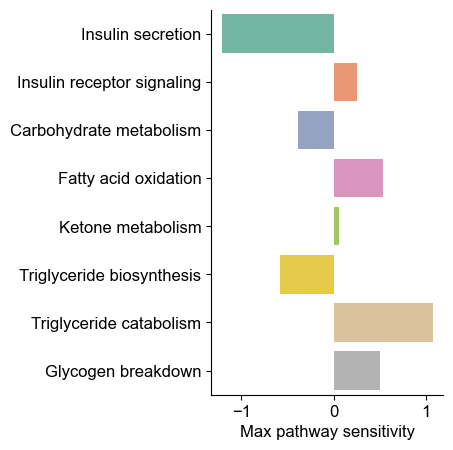

In [15]:
# Make a bar graph of the glucose sensitivity indices
fig, ax = plt.subplots(1, 1, figsize=(3, 5),)

# Order by the glucose sensitivity
order = df.sort_values(by=['Pathway','I'])['ParameterDescription']

sns.barplot(data=df, y="Pathway" ,x='I', ax=ax, legend=False, 
            order=order_list, estimator=find_largest_magnitude, errorbar=None, palette='Set2',)
#plt.xlim(-2.5, 1.2)

sns.despine()
ax.set_xlabel("Max pathway sensitivity")
ax.set_ylabel("")

# Put the legend outside the plot
#ax.legend(loc='center left', bbox_to_anchor=(0.8, 0.95,) , frameon=False)    

# Save the figure
plt.savefig("output/sensitivity_insulin.svg", bbox_inches='tight')

/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_27791/389404129.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, y="Pathway" ,x='L', ax=ax, legend=False,


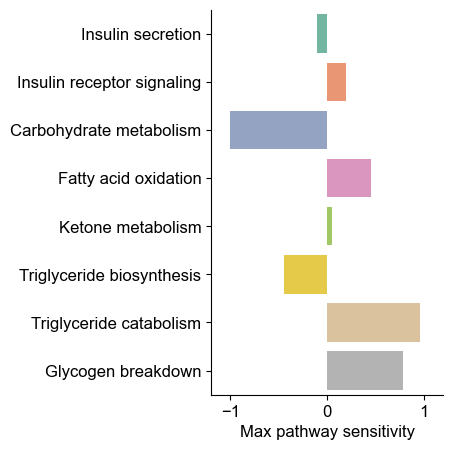

In [16]:
# Make a bar graph of the glucose sensitivity indices
fig, ax = plt.subplots(1, 1, figsize=(3,5),)

order = df.sort_values(by=['Pathway','L'])['ParameterDescription']

sns.barplot(data=df, y="Pathway" ,x='L', ax=ax, legend=False, 
            order=order_list, estimator=find_largest_magnitude, errorbar=None, palette='Set2',)
plt.xlim(-1.2, 1.2)

sns.despine()
ax.set_xlabel("Max pathway sensitivity")
ax.set_ylabel("")  

# Save the figure
plt.savefig("output/sensitivity_lactate.svg", bbox_inches='tight')

/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_27791/108679839.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, y="Pathway" ,x='K', ax=ax, legend=False,


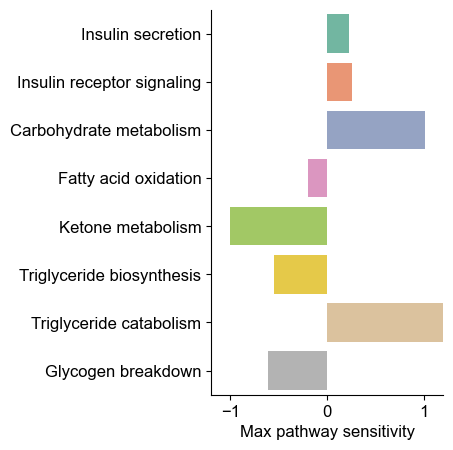

In [17]:
# Make a bar graph of the glucose sensitivity indices
fig, ax = plt.subplots(1, 1, figsize=(3, 5),)

order = df.sort_values(by=['Pathway','K'])['ParameterDescription']

sns.barplot(data=df, y="Pathway" ,x='K', ax=ax, legend=False, 
            order=order_list, estimator=find_largest_magnitude, errorbar=None, palette='Set2',)
plt.xlim(-1.2, 1.2)

sns.despine()
ax.set_xlabel("Max pathway sensitivity")
ax.set_ylabel("")  


# Put the legend outside the plot
#ax.legend(loc='center left', bbox_to_anchor=(0.8, 0.95,) , frameon=False)    

# Save the figure
plt.savefig("output/sensitivity_ketone.svg", bbox_inches='tight')

/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_27791/725868420.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, y="ParameterDescription" ,x='F', ax=ax, legend=False,


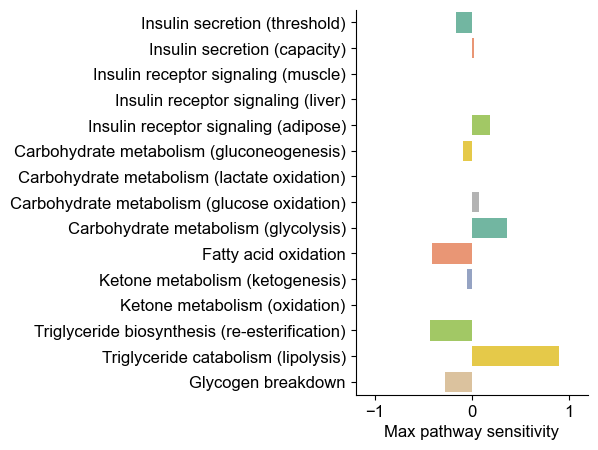

In [18]:
# Make a bar graph of the glucose sensitivity indices
fig, ax = plt.subplots(1, 1, figsize=(3, 5),)

order = df.sort_values(by=['Pathway','F'])['ParameterDescription']

sns.barplot(data=df, y="ParameterDescription" ,x='F', ax=ax, legend=False, 
            order=order, estimator=find_largest_magnitude, errorbar=None, palette='Set2',)
plt.xlim(-1.2, 1.2)

sns.despine()
ax.set_xlabel("Max pathway sensitivity")
ax.set_ylabel("")  
 

# Save the figure
plt.savefig("output/sensitivity_fatty_acids.svg", bbox_inches='tight')

In [19]:
df

,Parameter,L,G,F,K,I,vL,vG,vF,vK,vGL,vFK,vLG,v0,vA,vR,Condition,Direction,ParameterDescription,Pathway
0,Imax,-5.423228e-03,-2.002513e-01,1.919244e-02,-0.157559,3.667493e-01,-5.134116e-04,-3.440968e-04,0.024102,-1.526497e-01,-3.440968e-04,-1.526497e-01,-5.407650e-06,-0.0,-1.238080e-01,-1.802513e-01,Healthy,-1,Insulin secretion (capacity),Insulin secretion
1,C,-1.028122e-01,6.286243e-01,-1.591047e-01,0.220857,-1.215097e+00,1.173148e-03,7.467403e-04,-0.055119,3.248425e-01,7.467403e-04,3.248425e-01,-1.064539e-04,0.0,3.299860e-01,4.672725e-01,Healthy,1,Insulin secretion (threshold),Insulin secretion
2,KI_lipo,1.953760e-01,7.726690e-02,1.865563e-01,0.252170,2.467677e-01,1.673666e-04,1.724288e-04,-0.008652,5.696099e-02,1.724288e-04,5.696099e-02,1.825532e-04,0.0,1.800442e-01,2.617098e-01,Healthy,1,Insulin receptor signaling (adipose),Insulin receptor signaling
3,KA_glut4,0.000000e+00,0.000000e+00,-1.601713e-16,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,-3.203427e-16,0.000000e+00,0.0,0.000000e+00,0.000000e+00,Healthy,1,Insulin receptor signaling (muscle),Insulin receptor signaling
4,KI_F,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,-3.203427e-16,0.000000e+00,0.0,0.000000e+00,0.000000e+00,Healthy,1,Insulin receptor signaling (liver),Insulin receptor signaling
5,omega,8.436686e-01,-1.228871e-01,3.666283e-01,1.009128,-3.911085e-01,4.084040e-01,-7.404928e-01,-0.068636,5.738634e-01,2.595072e-01,5.738634e-01,1.144777e-03,-0.0,1.606022e-01,2.414698e-01,Healthy,-1,Carbohydrate metabolism (glycolysis),Carbohydrate metabolism
6,lam,-9.998240e-01,-3.386911e-05,9.016675e-05,0.000248,-1.087492e-04,7.195510e-05,-1.923180e-04,-0.000014,1.441161e-04,-1.923180e-04,1.441159e-04,-7.207190e-04,-0.0,4.036949e-05,5.565744e-05,Healthy,-1,Carbohydrate metabolism (lactate oxidation),Carbohydrate metabolism
7,gamma,-1.327152e-01,-2.473821e-02,6.923672e-02,0.193863,-7.930025e-02,-2.174664e-01,8.514052e-01,-0.015515,1.091118e-01,-1.485948e-01,1.091118e-01,-1.266727e-04,-0.0,3.004675e-02,4.401638e-02,Healthy,-1,Carbohydrate metabolism (glucose oxidation),Carbohydrate metabolism
8,beta,4.564381e-01,1.651384e-01,-4.126630e-01,-0.194268,5.353639e-01,-2.689113e-03,-1.614789e-03,0.128210,-6.533949e-01,-1.614789e-03,-6.533949e-01,5.362627e-04,-0.0,-1.730197e-01,-2.440325e-01,Healthy,-1,Fatty acid oxidation,Fatty acid oxidation
9,kappa,1.121199e-15,3.203427e-16,-1.601713e-15,-1.000000,1.121199e-15,2.883084e-15,2.082227e-15,-0.000000,-7.367881e-15,2.242399e-15,-1.922056e-15,1.601713e-16,-0.0,-6.406853e-16,-9.610280e-16,Healthy,-1,Ketone metabolism (oxidation),Ketone metabolism
